<a href="https://colab.research.google.com/github/Davron030901/PyTorch/blob/main/ResNet_for_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

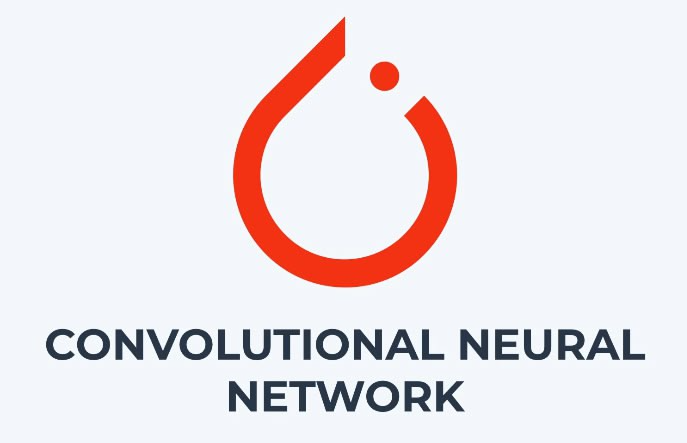

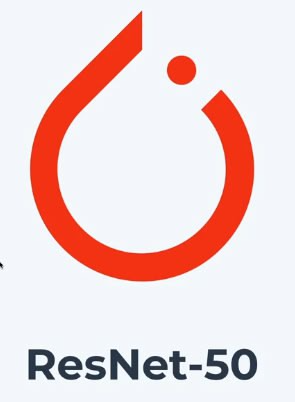

#ResNet

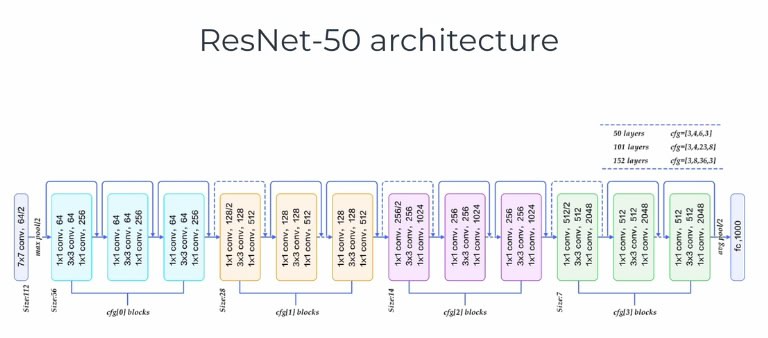

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2025-02-01 06:12:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   196MB/s    in 0.3s    

2025-02-01 06:12:48 (196 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip -d data cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: data/cats_and_dogs_filtered/
  inflating: data/cats_and_dogs_filtered/vectorize.py  
   creating: data/cats_and_dogs_filtered/validation/
   creating: data/cats_and_dogs_filtered/train/
   creating: data/cats_and_dogs_filtered/validation/dogs/
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/d

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from pathlib import Path
from PIL import Image
import torchvision.transforms as T

from torchvision.models import resnet50

In [ ]:
dir_train = Path('/content/data/cats_and_dogs_filtered/train')
dir_test = Path('/content/data/cats_and_dogs_filtered/validation')

In [ ]:
transform = T.Compose([
    T.Resize((256, 256)),
    # T.RandomHorizontalFlip(),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class CatDogDataset(Dataset):

  def __init__(self,path,transform = None):
    self.data_list = list(path.glob('*/*.jpg'))
    self.transform = transform

  def __getitem__(self,idx):
    img = Image.open(self.data_list[idx])
    if self.transform:
          img = self.transform(img)
    # img = img.numpy().astype(np.float32)
    if 'dogs' == str(self.data_list[idx]).split('/')[-2]:
      label = 1
    elif 'cats' == str(self.data_list[idx]).split('/')[-2]:
      label = 0

    return img,torch.tensor(label)
  def __len__(self):
    return len(self.data_list)

In [ ]:
train_data = CatDogDataset(dir_train, transform)
test_data = CatDogDataset(dir_test, transform)

In [ ]:
print(f"TRAIN: {len(train_data)}  TEST: {len(test_data)}")

TRAIN: 2000  TEST: 1000


In [ ]:
train_data_loader = DataLoader(train_data,
                        batch_size=25,
                        shuffle=True)

test_data_loader = DataLoader(test_data,
                        batch_size=25,
                        shuffle=True)

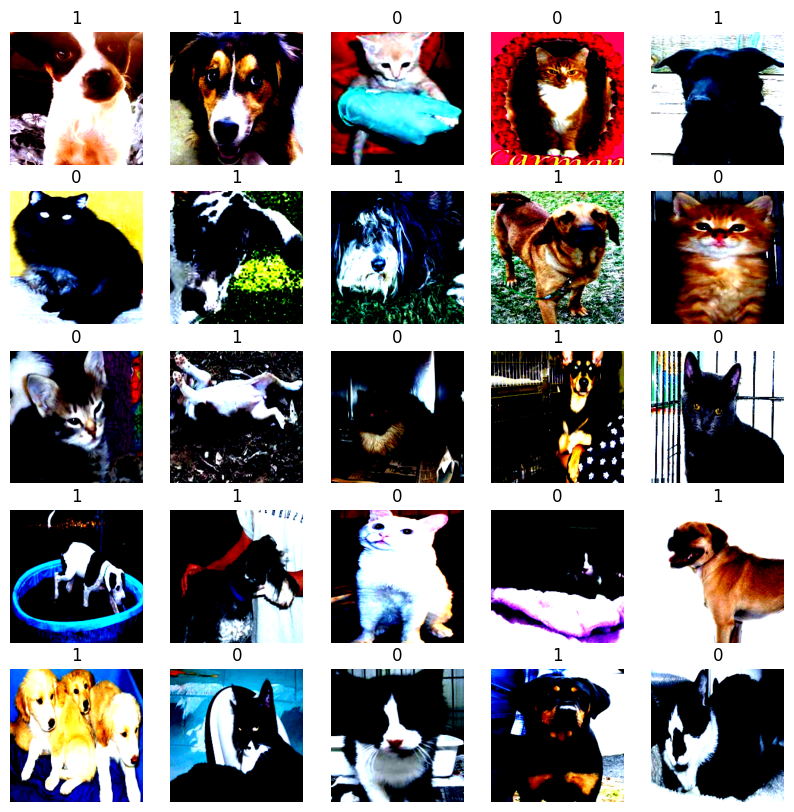

In [ ]:
plt.figure(figsize=(10, 10))

batch_data, batch_label = next(iter(test_data_loader))
i = 1
for img, label in zip(batch_data, batch_label):
  plt.subplot(5,5,i)
  img = img.numpy()
  img = np.transpose(img, (1,2,0))
  plt.title(str(label.item()))
  plt.imshow(img)
  plt.axis("off")
  i += 1
plt.show()

In [ ]:
model = resnet50(num_classes=2)

In [ ]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cpu")
if not train_on_gpu:
  print('CUDA is not available. Training on CPU...')
else:
  print('CUDA is available. Training on GPU')

if train_on_gpu:
  device = torch.device("cuda")
  model.cuda()

CUDA is available. Training on GPU


In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(self.epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{self.epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')

In [ ]:
epochs=10
trainer = Trainer(
    model = model.to(device),
    train_dataloader=train_data_loader,
    test_dataloader=test_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
)

In [ ]:
trainer.train()

100%|██████████| 40/40 [00:07<00:00,  5.57it/s]



Epoch[1/10] 	 train_loss: 0.61484, train_acc: 0.67 	 val_loss: 0.63578 	 val_acc: 0.68


100%|██████████| 40/40 [00:07<00:00,  5.56it/s]



Epoch[2/10] 	 train_loss: 0.58898, train_acc: 0.70 	 val_loss: 0.65195 	 val_acc: 0.67


100%|██████████| 40/40 [00:07<00:00,  5.68it/s]



Epoch[3/10] 	 train_loss: 0.60900, train_acc: 0.67 	 val_loss: 0.59693 	 val_acc: 0.69


100%|██████████| 40/40 [00:06<00:00,  5.92it/s]



Epoch[4/10] 	 train_loss: 0.58507, train_acc: 0.70 	 val_loss: 0.58062 	 val_acc: 0.7


100%|██████████| 40/40 [00:06<00:00,  6.06it/s]



Epoch[5/10] 	 train_loss: 0.54389, train_acc: 0.72 	 val_loss: 0.58728 	 val_acc: 0.7


100%|██████████| 40/40 [00:06<00:00,  6.07it/s]



Epoch[6/10] 	 train_loss: 0.53580, train_acc: 0.73 	 val_loss: 0.61380 	 val_acc: 0.71


100%|██████████| 40/40 [00:06<00:00,  6.08it/s]



Epoch[7/10] 	 train_loss: 0.53910, train_acc: 0.73 	 val_loss: 0.59870 	 val_acc: 0.7


100%|██████████| 40/40 [00:06<00:00,  6.10it/s]



Epoch[8/10] 	 train_loss: 0.52321, train_acc: 0.74 	 val_loss: 0.56845 	 val_acc: 0.71


100%|██████████| 40/40 [00:06<00:00,  5.99it/s]



Epoch[9/10] 	 train_loss: 0.48771, train_acc: 0.77 	 val_loss: 0.56639 	 val_acc: 0.72


100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


Epoch[10/10] 	 train_loss: 0.49645, train_acc: 0.77 	 val_loss: 0.57033 	 val_acc: 0.73


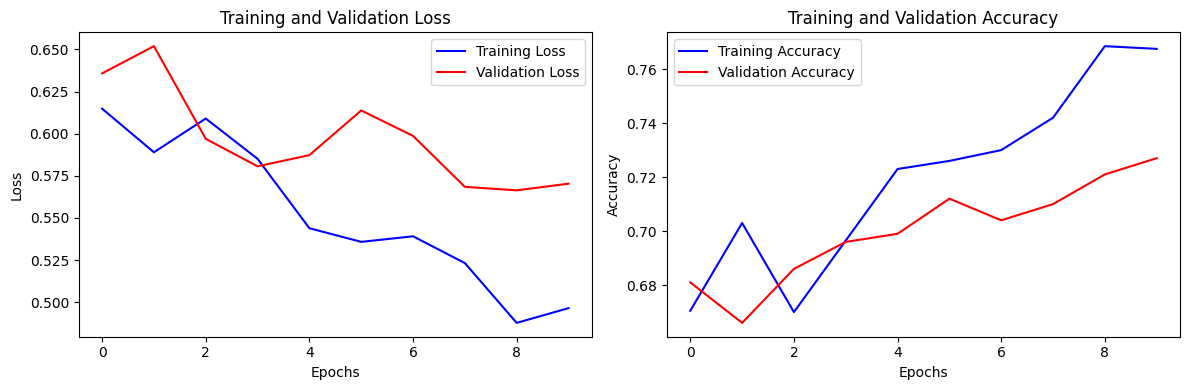

In [ ]:
# Create subplots for loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
axs[0].plot(trainer.history['loss'], 'b', label='Training Loss')
axs[0].plot(trainer.history['val_loss'], 'r', label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# # Plot training and validation accuracy
axs[1].plot(trainer.history['acc'], 'b', label='Training Accuracy')
axs[1].plot(trainer.history['val_acc'], 'r', label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

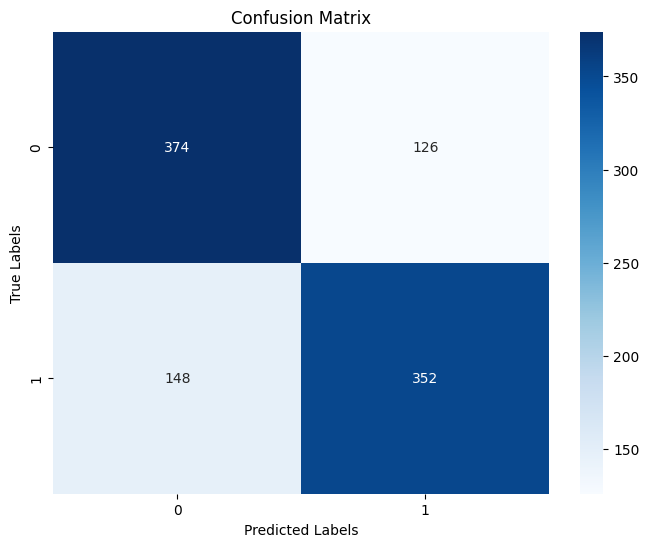

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = []
true_labels = []

with torch.no_grad():
    for data, labels in test_data_loader:
        data, labels = data.to(device), labels.to(device)
        output = model(data)
        predictions.extend(output.argmax(dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using seaborn
classes = range(len(conf_matrix))
labels = [str(i) for i in classes]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()